# Fitting

In [1]:
import sys
sys.path.insert(0, '../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle as pkl
import tensorflow as tf

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from kraus_channels import KrausMap
from loss_functions import ProbabilityMSE, ProbabilityRValue, channel_fidelity_loss
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import DilutedChannel, ChoiMapStatic
from quantum_tools import apply_unitary, measurement, resample, state_fidelity
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits
from spam import SPAM, InitialState, POVMwQR as POVM, IdealPOVM, IdealInit, povm_fidelity, CorruptionMatrix
from synthetic_data import generate_spam_data, generate_map_data
from utils import saver, loader, train_val_split
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum
from qiskit.circuit.library import iSwapGate


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2024-12-05 14:26:50.008721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_data(filename, L, n):
    with open(filename, 'rb') as f:
        data = pkl.load(f)

    targets = counts_to_probs(data)
    targets_spam = targets[:6**n]
    targets_map = targets[6**n:]

    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
    circuit_target = pqc_basic(n, L)
    unitary = Operator(circuit_target).data

    inputs_spam, _ = generate_pauliInput_circuits(n)
        
    inputs_map, circuit_list_map = (
                generate_pauli_circuits(n, None, N=5000-6**n)
        )
    
    return inputs_spam, targets_spam, inputs_map, targets_map, unitary

def fit_spam(inputs, 
             targets,
             num_iter = 2000):
    d = targets.shape[1]
    spam_model = SPAM(init = InitialState(d),
                    povm = CorruptionMatrix(d),
                    )

    spam_opt = ModelSPAM(spam_model, tf.keras.optimizers.Adam(learning_rate=0.01))
        
    spam_opt.pretrain(100, verbose=False)

    spam_opt.train(inputs = inputs,
                    targets = targets,
                    num_iter = num_iter,
                    verbose = False,
                )
    
    return spam_model
    

def fit_model(inputs, 
              targets, 
              spam_model,
              num_iter = 2000):
    d = targets.shape[1]
    model = ModelQuantumMap(channel = KrausMap(d = d, 
                                        rank = d**2,
                                        spam = spam_model,
                                        ),
                    loss_function = ProbabilityMSE(),
                    optimizer = tf.optimizers.Adam(learning_rate=0.01),
                    logger = Logger(loss_function_list = [ProbabilityRValue()], sample_freq=100),
                )

    model.train(inputs = inputs,
                targets = targets,
                inputs_val = [inputs],
                targets_val = [targets],
                num_iter = num_iter,
                N = 500,
                verbose=False
                )
    
    return model

## Loss as a function of Depth

In [3]:
n = 4
d = 2**n

num_layer_list = [8, 16, 24, 32, 40, 56, 72, 88, 104, 120]


loss_list = []

for num_layer in num_layer_list:
    model = pkl.load(open(f"models/L={num_layer}.model", "rb"))[0]
    loss = model.logger.loss_list[0][-1]
    loss_list.append(loss)    

2024-12-05 14:26:53.640767: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


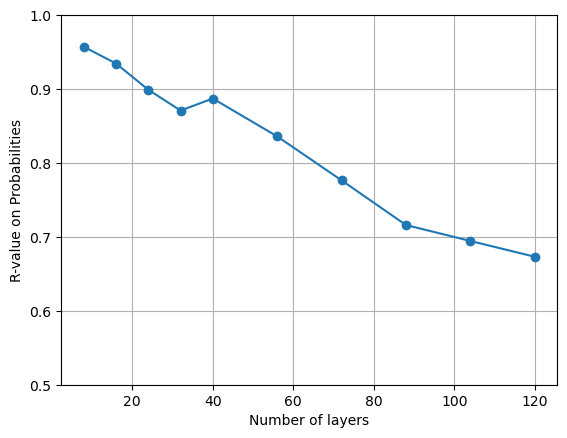

In [5]:
plt.plot(num_layer_list, loss_list, "-o")
plt.xlabel("Number of layers")
plt.ylabel("R-value on Probabilities")
plt.ylim(0.5, 1)
plt.grid()
plt.savefig("figures/loss_curve.pdf")
plt.show()